In [1]:
#!pip install scapy
#!pip install pandas
#!pip install matplotlib
#!pip install networkx


In [2]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
from datetime import datetime # Datetime - Convert Epoch to Datetime
import socket # Socket - Convert protocol numbers to protocol names
import networkx as nx # NetworkX - Create and Manipulate Graphs
import ipaddress # IPAddress - Check for multicast and broadcast addresses
import time # Measure time it takes to run

In [3]:
pcap_name = "The Ultimate PCAP v20221220.pcapng"

In [4]:
protocol_to_numbers = {'hopopt': 0, 'icmp': 1, 'igmp': 2, 'ggp': 3, 'ipv4': 4, 'st': 5, 'tcp': 6, 'cbt': 7, 
    'egp': 8, 'igp': 9, 'bbn-rcc-mon': 10, 'nvp-ii': 11, 'pup': 12, 'emcon': 14, 'xnet': 15, 'chaos': 16, 'udp': 17, 'mux': 18,
    'dcn-meas': 19, 'hmp': 20, 'prm': 21, 'xns-idp': 22, 'trunk-1': 23, 'trunk-2': 24, 'leaf-1': 25, 'leaf-2': 26, 'rdp': 27, 
    'irtp': 28, 'iso-tp4': 29, 'netblt': 30, 'mfe-nsp': 31, 'merit-inp': 32, 'dccp': 33, '3pc': 34, 'idpr': 35, 'xtp': 36, 
    'ddp': 37, 'idpr-cmtp': 38, 'tp++': 39, 'il': 40, 'ipv6': 41, 'sdrp': 42, 'ipv6-route': 43, 'ipv6-frag': 44, 'idrp': 45,
    'rsvp': 46, 'gre': 47, 'dsr': 48, 'bna': 49, 'esp': 50, 'ah': 51, 'i-nlsp': 52, 'narp': 54, 'mobile': 55, 'tlsp': 56, 
    'skip': 57, 'ipv6-icmp': 58, 'ipv6-nonxt': 59, 'ipv6-opts': 60, 'cftp': 62, 'sat-expak': 64, 'kryptolan': 65, 'rvd': 66,
    'ippc': 67, 'sat-mon': 69, 'visa': 70, 'ipcv': 71, 'cpnx': 72, 'cphb': 73, 'wsn': 74, 'pvp': 75, 'br-sat-mon': 76, 
    'sun-nd': 77, 'wb-mon': 78, 'wb-expak': 79, 'iso-ip': 80, 'vmtp': 81, 'secure-vmtp': 82, 'vines': 83, 'ttp': 84,
    'iptm': 84, 'nsfnet-igp': 85, 'dgp': 86, 'tcf': 87, 'eigrp': 88, 'ospfigp': 89, 'sprite-rpc': 90,
    'larp': 91, 'mtp': 92, 'ax.25': 93, 'ipip': 94, 'scc-sp': 96, 'etherip': 97, 'encap': 98, 'gmtp': 100, 
    'ifmp': 101, 'pnni': 102, 'pim': 103, 'aris': 104, 'scps': 105, 'qnx': 106, 'a/n': 107, 'ipcomp': 108, 
    'snp': 109, 'compaq-peer': 110, 'ipx-in-ip': 111, 'vrrp': 112, 'pgm': 113, 'l2tp': 115, 'ddx': 116, 'iatp': 117, 
    'stp': 118, 'srp': 119, 'uti': 120, 'smp': 121, 'ptp': 123, 'fire': 125, 'crtp': 126, 'crudp': 127, 'sscopmce': 128, 
    'iplt': 129, 'sps': 130, 'pipe': 131, 'sctp': 132, 'fc': 133, 'rsvp-e2e-ignore': 134, 'udplite': 136, 'mpls-in-ip': 137,
      'manet': 138, 'hip': 139, 'shim6': 140, 'wesp': 141, 'rohc': 142, 'ethernet': 143, 'aggfrag': 144, 'rsvp-e2e': 145}

# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

def get_protocol_name(protocol_number):
    for protocol_name, number in protocol_to_numbers.items():
        if number == protocol_number:
            return protocol_name
    return "Unknown"

In [5]:
class PCAPToDataFrame:
    def __init__(self, capture_file):
        self.capture_file = capture_file
        self.data_list = []

    def data_extract(self, packet):

        if not packet.haslayer(IP):
            #print("Packet does not have an IP layer, skipping")
            #print(packet.summary()) 
            #print(packet.show()) 
            return

        if not packet.haslayer(Ether):
            #print("Packet does not have an Ethernet layer, skipping")
            #print(packet.summary()) 
            #print(packet.show()) 
            return

        # Convert the timestamp to a readable UTC time
        time = datetime.utcfromtimestamp(int(packet.time)).strftime('%Y-%m-%d %H:%M:%S')
        protocol = get_protocol_name(int(packet[IP].proto))

        # Extract the desired data from the packet
        data = {
            "time": time,
            "src_ip": packet[IP].src,
            "src_mac": packet[Ether].src,
            "dst_ip": packet[IP].dst,
            "dst_mac": packet[Ether].dst,
            "protocol": protocol,
            "payload_size": len(packet[IP].payload)
        }

        # Check if the source or destination IP address is a multicast address
        src_ip = ipaddress.ip_address(packet[IP].src)
        dst_ip = ipaddress.ip_address(packet[IP].dst)
        if src_ip.is_multicast or dst_ip.is_multicast:
            data["multicast"] = True
        else:
            data["multicast"] = False

        # Check if the source and destination IP addresses are both private
        src_ip = ipaddress.ip_address(packet[IP].src)
        dst_ip = ipaddress.ip_address(packet[IP].dst)
        if src_ip.is_private and dst_ip.is_private:
            data["private_to_private"] = True
        else:
            data["private_to_private"] = False

        # Check if the destination IP address is a broadcast address
        dst_ip = ipaddress.ip_address(packet[IP].dst)
        if not dst_ip.is_global and dst_ip.is_link_local:
            data["dst_broadcast"] = True
        else:
            data["dst_broadcast"] = False

        # Extract the source and destination port numbers if they are present
        if packet.haslayer(TCP):
            data["src_port"] = int(packet[TCP].sport)
            data["dst_port"] = int(packet[TCP].dport)

        if packet.haslayer(UDP):
            data["src_port"] = int(packet[UDP].sport)
            data["dst_port"] = int(packet[UDP].dport)

        # Accumulate the data in a list
        self.data_list.append(data)

    def read_pcap_to_dataframe(self):
        def data_extract_wrapper(packet):
            self.data_extract(packet)

        # Start time to read pcap time
        start_time = time.time()

        # Read the PCAP file and extract the data
        packets = sniff(offline=self.capture_file, prn=data_extract_wrapper, store=0)

        # Create a Pandas DataFrame from the data
        df = pd.DataFrame(self.data_list)
        
        # Record time taken to process the PCAP file
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Elapsed time: {elapsed_time} seconds')

        return df

In [6]:
# Create an instance of the PCAPToDataFrame class
pcap_to_df = PCAPToDataFrame(pcap_name)

# Read the PCAP file and create a DataFrame
df = pcap_to_df.read_pcap_to_dataframe()

Elapsed time: 12.752277135848999 seconds


In [7]:
df["time"] = pd.to_datetime(df["time"])  # Convert the time column to a datetime object
df["seconds_from_epoch"] = pd.DatetimeIndex(df["time"]).asi8 / 1e9 # Add a column with the seconds from epoch
df.head(3)

,time,src_ip,src_mac,dst_ip,dst_mac,protocol,payload_size,multicast,private_to_private,dst_broadcast,src_port,dst_port,seconds_from_epoch
0,2012-12-11 19:26:02,10.0.0.1,c2:3d:19:6c:00:01,224.0.0.2,01:00:5e:00:00:02,udp,42,True,False,False,646.0,646.0,1.355254e+09
1,2012-12-11 19:26:02,10.0.0.1,c2:3d:19:6c:00:01,224.0.0.2,01:00:5e:00:00:02,udp,42,True,False,False,646.0,646.0,1.355254e+09
2,2012-12-11 19:26:02,10.0.0.2,c2:3c:19:6c:00:01,224.0.0.2,01:00:5e:00:00:02,udp,42,True,False,False,646.0,646.0,1.355254e+09


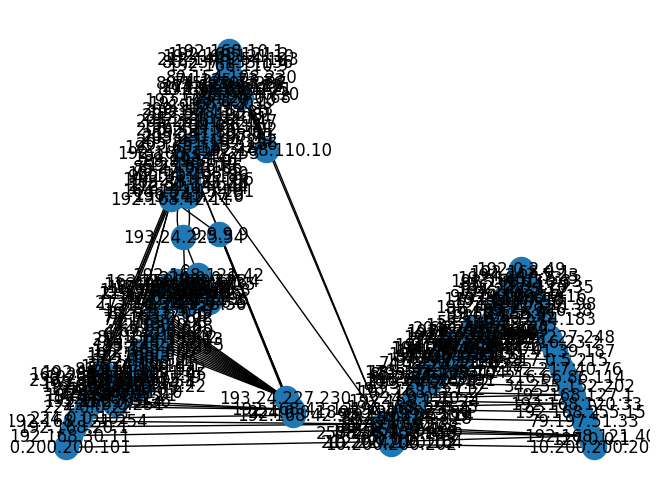

In [8]:
df1 = df[['src_ip', 'src_mac', 'dst_ip', 'dst_mac']]
G = nx.Graph()
G = nx.from_pandas_edgelist(df1, 'src_ip', 'dst_ip', create_using=nx.Graph())
nx.draw_planar(G, with_labels = True) 


In [9]:
# Filter the dataframe to only show rows where the source and destination IP addresses are both private
filtered_df = df[df["private_to_private"] == True]